# Artigo Induscon 2023

## Pre processamento

Pré-processamento dos dados de pesquisa no IEEE Xplore obtidos com os seguintes filtros:

- Search terms: "OPC UA"
- Language: English
- Date range: Last 5 years

#### Importação dos pacotes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

#### Preâmbulo

In [2]:
input_path = './Build/Search1/Input'
output_path = './Build/Search1/Output'
img_path = './Images'

# COLORS
grid_gray = '#E5E4E2'
warm1 = '#F94144'
warm2 = '#F3722C'
warm3 = '#F8961E'
warm4 = '#F9844A'
warm5 = '#F9C74F'
cold1 = '#90BE6D'
cold2 = '#43AA8B'
cold3 = '#4D908E'
cold4 = '#577590'
cold5 = '#277DA1'

#### Carregando as bases de dados

Base dos dados obtidos na primeira pesquisa já classificados.

In [3]:
df = pd.read_excel(f'{input_path}/opcua5years_pre2.xlsm')
drop_labels = ['Author Affiliations','Date Added To Xplore','Volume',
               'Issue','Start Page','End Page','ISSN','ISBNs','DOI',
               'Funding Information','PDF Link','INSPEC Controlled Terms',
               'INSPEC Non-Controlled Terms','Mesh_Terms','Article Citation Count',
               'Patent Citation Count','Reference Count','License','Online Date',
               'Issue Date','Meeting Date','Publisher']
classified = df.drop(labels=drop_labels, axis=1)
classified['Category'] = list(classified['Category'].str.split(";", expand=False))
classified['Authors'] = list(classified['Authors'].str.split(";", expand=False))
classified.index += 2
classified.head(2)

,Category,Document Title,Authors,Publication Title,Publication Year,Abstract,Author Keywords,IEEE Terms,Document Identifier
2,[Product Development (PD)],Towards a Web-of-Things Approach for OPC UA Fi...,"[Q. -D. Nguyen, S. Dhouib, J. -P. Chanet, P...",2022 IEEE 18th International Conference on Fac...,2022,"In the opc UA standard, the opc UA information...",Industry;Internet of Things;OPC UA;Web of Thin...,Runtime;Conferences;Semantics;Manuals;Producti...,IEEE Conferences
3,[Redundancy and Availability (RA)],Practical Implementation of an OPC UA Multi-Se...,"[C. Pu, X. Ding, P. Wang, Y. Yang]",2022 IEEE International Conferences on Interne...,2022,The Open Platform Communication Unified Archit...,automated industry;OPC UA;TSN;server aggregation,Social computing;Data security;Configuration m...,IEEE Conferences


Base de dados obtida na segunda pesquisa, com os seguintes filtros:

- Search terms: "OPC UA" in Author Keywords
- Language: English
- Date range: Last 5 years

In [4]:
df = pd.read_csv(f'{input_path}/opcua5years_keywords2.csv')
new_query = df.drop(labels=drop_labels+['Authors','Publication Title','Publication Year','Abstract','Author Keywords','IEEE Terms','Document Identifier'], axis=1)
new_query_titles = new_query['Document Title'].tolist()

Dataframe com a base de dados já classificada e filtrada para aquelas que apenas tem OPC UA no Author Keywords

In [5]:
filtered_classified = classified[classified['Document Title'].isin(new_query_titles)]
filtered_classified.to_csv(f'{output_path}/filtered_classified.csv',sep=',',encoding='UTF-8')
filtered_classified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 237 entries, 2 to 293
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Category             237 non-null    object
 1   Document Title       237 non-null    object
 2   Authors              237 non-null    object
 3   Publication Title    237 non-null    object
 4   Publication Year     237 non-null    int64 
 5   Abstract             237 non-null    object
 6   Author Keywords      237 non-null    object
 7   IEEE Terms           221 non-null    object
 8   Document Identifier  237 non-null    object
dtypes: int64(1), object(8)
memory usage: 18.5+ KB


Separação dos dados em categorias (EXPLODE)

In [6]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    idx_cols = df.columns.difference(lst_cols)
    lens = df[lst_cols[0]].str.len()
    idx = np.repeat(df.index.values, lens)
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    if (lens == 0).any():
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    res = res.sort_index()
    if not preserve_index:
        res = res.reset_index(drop=True)
    return res

In [7]:
classified_explode_categories = filtered_classified.explode('Category')
classified_explode_categories['Category'].value_counts()

Category
Product Development (PD)            79
Integration (I)                     58
Performance Analysis (PA)           42
Protocol Comparison (PC)            35
Others (O)                          35
Diagnostic and Monitoring (DM)      33
Theory (T)                          28
Wireless Communication (W)          26
Security (S)                        25
Redundancy and Availability (RA)     9
Name: count, dtype: int64

## Consultas

Realizar as consultas na base para construir tabelas e gráficos da seção **Quantitative Analysis**

#### Número de publicações relacionadas com OPC UA por ano

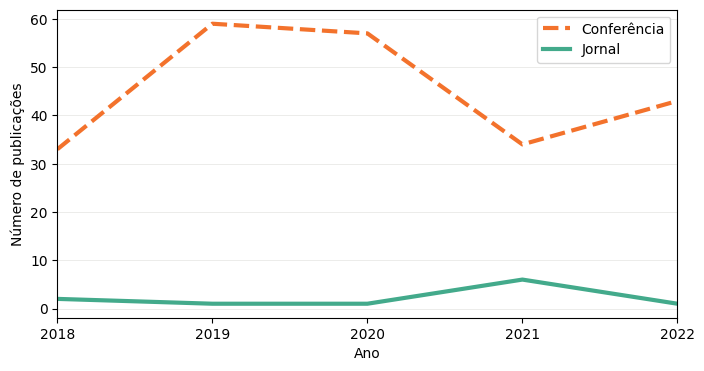

In [8]:
grouped1 = filtered_classified.groupby(['Publication Year', 'Document Identifier']).size().reset_index(name='Count')
pivot1 = grouped1.pivot(index='Publication Year', columns='Document Identifier', values='Count')
plt.figure(figsize=(8, 4))
# lines = pivot.plot(kind='line',linewidth=3)
plt.plot(pivot1.index, pivot1['IEEE Conferences'], linestyle='--', color=warm2, linewidth=3, label='Conferência')
plt.plot(pivot1.index, pivot1['IEEE Journals'], linestyle='-', color=cold2, linewidth=3, label='Jornal')
plt.xlabel('Ano')
plt.ylabel('Número de publicações')
plt.xlim(2018, 2022)
plt.xticks(range(2018, 2023, 1))
plt.legend(title='', loc='upper right')
plt.grid(axis = 'y', color=grid_gray, linewidth=0.5)
plt.savefig(f'{img_path}/pubPerYear.png', format='png', dpi=600)
plt.show()

Total de artigos em conferência e jornal

In [9]:
print('Conferência: ',pivot1['IEEE Conferences'].sum())
print('Jornal: ',pivot1['IEEE Journals'].sum())

Conferência:  226
Jornal:  11


Nomes dos jornais

In [20]:
filtered_classified[filtered_classified['Document Identifier'] == 'IEEE Journals']['Publication Title']

23           IEEE Transactions on Industrial Informatics
57     IEEE Transactions on Very Large Scale Integrat...
100                                          IEEE Access
135                                          IEEE Access
142                                          IEEE Access
145                                          IEEE Access
158    IEEE Transactions on Instrumentation and Measu...
164                              Proceedings of the IEEE
166                                          IEEE Access
174                                          IEEE Access
202          IEEE Transactions on Industrial Informatics
Name: Publication Title, dtype: object

Maior meio publicador

In [11]:
import re
from collections import Counter

pub_title_full = list(filtered_classified['Publication Title'])
journals = filtered_classified[filtered_classified['Document Identifier'] == 'IEEE Journals']
conferences = filtered_classified[filtered_classified['Document Identifier'] == 'IEEE Conferences']
pub_title_journal = list(journals['Publication Title'])
pub_title_conferences = list(conferences['Publication Title'])

# Regular expression pattern to extract text between parentheses
pattern = r'\((.*?)\)'

# Empty list to store the extracted text
pub_title_compact = []
for s in pub_title_full:
    result = re.findall(pattern, s)
    pub_title_compact.append(result[0] if result else None)

dict1 = Counter(pub_title_compact)
dict1 = dict(sorted(dict1.items(), key=lambda item: item[1]))

pub_title_journal_compact = []
for s in pub_title_journal:
    result = re.findall(pattern, s)
    pub_title_journal_compact.append(result[0] if result else None)

dict2 = Counter(pub_title_journal_compact)
dict2 = dict(sorted(dict2.items(), key=lambda item: item[1]))

pub_title_conference_compact = []
for s in pub_title_conferences:
    result = re.findall(pattern, s)
    pub_title_conference_compact.append(result[0] if result else None)

dict3 = Counter(pub_title_conference_compact)
dict3 = dict(sorted(dict3.items(), key=lambda item: item[1]))

print(dict1)
print('O maior publicador, tanto para conferências quanto para jornais, foi: ', list(dict1.keys())[-1])
print('Dos jornais: ', list(dict2.keys())[-1])
print('Das conferencias: ', list(dict3.keys())[-1])

{'iThings': 1, 'FarEastCon': 1, 'AEECA': 1, 'CIMPS': 1, 'CSCS': 1, 'IICSPI': 1, 'ICIS': 1, 'RusAutoCon': 1, 'ICAICA': 1, 'IPEC': 1, 'CNCIT': 1, 'ICCASIT': 1, 'ETCM': 1, 'Indo-Taiwan ICAN': 1, 'ICIBA': 1, 'NSENS': 1, 'REPE': 1, 'AI4I': 1, 'VLSI': 1, 'ICWCSG': 1, 'SmartWorld/SCALCOM/UIC/ATC/CBDCom/IOP/SCI': 1, 'IEEM': 1, 'ICBAIE': 1, 'ISETC': 1, 'CBI': 1, 'ICTC': 1, 'CTS': 1, 'IMCCC': 1, 'CISTI': 1, 'ICAI': 1, 'CASE': 1, 'ICEVT': 1, 'CACS': 1, 'CCDC': 1, 'IIAI-AAI': 1, 'ICSAI': 1, 'YEF-ECE': 1, 'RIVF': 1, 'CAMAD': 1, 'I2MTC': 1, "EPE '19 ECCE Europe": 1, 'MetroInd4.0&IoT': 1, "exp.at'19": 1, 'ICA-ACCA': 1, 'RTSI': 1, 'APSIPA ASC': 1, 'CCAC': 1, 'ECICE': 1, 'SIMS': 1, ' SDPC': 1, 'ICSPCC': 1, 'ICCI': 1, 'COINS': 1, 'CIYCEE': 1, 'ISORC': 1, 'DSD': 1, 'ICCC': 1, 'ICII': 1, 'ENERGYCON': 1, 'ICPECA': 1, 'ICICTA': 1, 'ICTAI': 1, 'AICT': 1, 'IDAACS': 1, 'ME': 1, 'ISSE': 1, 'TOCS': 2, 'ICE/ITMC': 2, 'SAMI': 2, 'ICCMA': 2, 'ITNEC': 2, 'ITNAC': 2, 'ICTech': 2, 'WF-IoT': 2, 'ICCAR': 2, 'TELFOR': 2,

Escritores com maior quantidade de publicações

In [12]:
# authors_explode = filtered_classified.explode('Authors')['Authors']
authors_explode = filtered_classified.explode('Authors')
vc = authors_explode['Authors'].value_counts()
author = vc.index[3]
categories = authors_explode[authors_explode['Authors'] == author]['Category']
print(categories.values)

[list(['Wireless Communication (W)', 'Performance Analysis (PA)', 'Integration (I)'])
 list(['Protocol Comparison (PC)', 'Performance Analysis (PA)'])
 list(['Integration (I)']) list(['Protocol Comparison (PC)'])
 list(['Product Development (PD)', 'Diagnostic and Monitoring (DM)', 'Others (O)'])
 list(['Others (O)'])]


Coexistência de categorias

#### Quantidade de artigos por categorias (Tabela)

In [13]:
grouped2 = classified_explode_categories.groupby(['Publication Year', 'Category']).size().reset_index(name='Count')
pivot2 = grouped2.pivot(index='Publication Year', columns='Category', values='Count')
pivot2

Category,Diagnostic and Monitoring (DM),Integration (I),Others (O),Performance Analysis (PA),Product Development (PD),Protocol Comparison (PC),Redundancy and Availability (RA),Security (S),Theory (T),Wireless Communication (W)
Publication Year,,,,,,,,,,
2018,2,11,4,5,12,2,2,4,3,2
2019,10,14,9,10,20,10,1,6,7,7
2020,13,14,12,8,13,10,3,6,8,6
2021,3,11,2,12,16,6,1,4,6,7
2022,5,8,8,7,18,7,2,5,4,4


In [14]:
classified_explode_categories[classified_explode_categories['Category'] == 'Product Development (PD)'][['Document Title','Abstract']].to_csv(f'{output_path}/product_development.csv',sep=',',encoding='UTF-8')
classified_explode_categories[classified_explode_categories['Category'] == 'Diagnostic and Monitoring (DM)'][['Document Title','Abstract']].to_csv(f'{output_path}/diagnostic_monitoring.csv',sep=',',encoding='UTF-8')
classified_explode_categories[classified_explode_categories['Category'].isin(['Integration (I)','Theory (T)'])][['Document Title','Abstract']].to_csv(f'{output_path}/theory_integration.csv',sep=',',encoding='UTF-8')
classified_explode_categories[classified_explode_categories['Category'] == 'Others (O)'][['Document Title','Abstract']].to_csv(f'{output_path}/others.csv',sep=',',encoding='UTF-8')
classified_explode_categories[classified_explode_categories['Category'] == 'Performance Analysis (PA)'][['Document Title','Abstract']].to_csv(f'{output_path}/performance_analysis.csv',sep=',',encoding='UTF-8')
classified_explode_categories[classified_explode_categories['Category'] == 'Protocol Comparison (PC)'][['Document Title','Abstract']].to_csv(f'{output_path}/protocol_comparison.csv',sep=',',encoding='UTF-8')
classified_explode_categories[classified_explode_categories['Category'] == 'Security (S)'][['Document Title','Abstract']].to_csv(f'{output_path}/security.csv',sep=',',encoding='UTF-8')
classified_explode_categories[classified_explode_categories['Category'] == 'Wireless Communication (W)'][['Document Title','Abstract']].to_csv(f'{output_path}/wireless_communication.csv',sep=',',encoding='UTF-8')